Estação: Passo Migliavaca (código 86480000)<br>
Período analisado: 1980 a 2015

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "C:\\ENS\\Hidrologia"
dados = pd.read_excel(path+'\\Dados_ANA.xlsx')
dados = dados.set_index('Data') 
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13149 entries, 1980-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vazão   13149 non-null  float64
dtypes: float64(1)
memory usage: 205.5 KB


In [3]:
dados['Média móvel'] = dados['Vazão'].rolling(window=7).mean()
dados = dados.groupby(dados.index.year).min()  
dados = dados.rename(columns={'Média móvel': 'Q7 (m³/s)'})
dados = dados.drop('Vazão', axis='columns')    
dados['Ordem i'] = range(1, len(dados['Q7 (m³/s)'])+1)
dados['Q ord (m³/s)'] = sorted(dados['Q7 (m³/s)'])
dados['Tr empírico (anos)'] = (len(dados['Q7 (m³/s)'])+1)/dados['Ordem i']
dados.head()

,Q7 (m³/s),Ordem i,Q ord (m³/s),Tr empírico (anos)
Data,,,,
1980,2.450700,1,0.399771,37.000000
1981,3.015671,2,0.656300,18.500000
1982,1.377900,3,0.872300,12.333333
1983,7.204957,4,1.120157,9.250000
1984,2.042257,5,1.153871,7.400000


In [4]:
def Gumbel(alfa, beta, Kp):
    return alfa + (beta*Kp)
    
alfa = dados['Q7 (m³/s)'].mean() + (0.45*dados['Q7 (m³/s)'].std())
beta = 0.7797*dados['Q7 (m³/s)'].std()

Tr = np.exp(np.linspace(np.log(1.001), np.log(100), 300))
modelo = pd.DataFrame(data=Tr, columns=['Tr (anos)'])
modelo['Kp'] = np.log(-np.log(1-(1/modelo['Tr (anos)'])))
modelo['Q Gumbel (m³/s)'] = Gumbel(alfa, beta, modelo['Kp'])
modelo.head()

,Tr (anos),Kp,Q Gumbel (m³/s)
0,1.001000,1.932789,7.015623
1,1.016533,1.415557,6.235036
2,1.032308,1.242497,5.973860
3,1.048327,1.123945,5.794947
4,1.064594,1.030413,5.653792


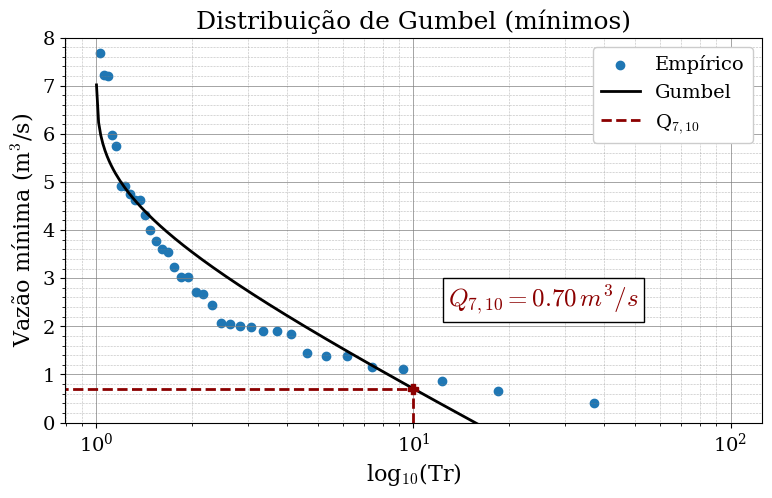

In [6]:
fig,ax = plt.subplots(figsize=(9,5)) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'  

ax.scatter(dados['Tr empírico (anos)'], 
           dados['Q ord (m³/s)'],
           label = 'Empírico')

ax.plot(modelo['Tr (anos)'], 
        modelo['Q Gumbel (m³/s)'], 
        color='black', 
        linewidth=2,
        label = 'Gumbel') 

kp = np.log(-np.log(1-(1/10)))
y = Gumbel(alfa, beta, kp) # Q7, 10 
ax.plot([0, 10], 
        [y, y],
        color='darkred',
        linestyle='--',
        linewidth=2,
        label = r'Q$_{7,10}$') 
ax.plot([10, 10], 
        [0, y],
        color='darkred',
        linestyle='--',
        linewidth=2) 
ax.plot(10, y, 
        marker='P', 
        color='darkred',
        markersize=7)

plt.text(0.55, 
         0.3, 
         rf'$Q_{{7,10}}={y:.2f}\, m^3/s$', 
         fontsize=18, 
         color='darkred',
         bbox={'facecolor': 'white', 'alpha': 1},
         transform=plt.gca().transAxes)

plt.xscale('log') 
plt.title('Distribuição de Gumbel (mínimos)', size = 18)
plt.xlabel(r'log$_{10}$(Tr)', size = 16)
plt.ylabel(r'Vazão mínima (m$^3$/s)', size = 16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
ax.grid(True,
        which='major', 
        color='gray', 
        linestyle='-',
        linewidth=0.5)
ax.grid(True,
        which='minor', 
        color='gray', 
        linestyle=':',
        linewidth=0.4)
ax.minorticks_on()
plt.ylim(0, 8)
plt.legend(fontsize=14, framealpha=1) 
plt.savefig(path+'\\gumbel_min.png', bbox_inches='tight') 